In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree , metrics
import matplotlib.pyplot as plt
import joblib
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [ ]:
# Custom transformer for text cleaning
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self._clean_text)
    
    def _clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return tokens

In [ ]:
# Custom transformer for Word2Vec vectorization
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=50, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
    
    def fit(self, X, y=None):
        self.model = Word2Vec(X, vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=self.workers)
        self.model.train(X, total_examples=len(X), epochs=20)
        return self
    
    def transform(self, X, y=None):
        return np.array([self._vectorize_text(text) for text in X])
    
    def _vectorize_text(self, text):
        vector = np.mean([self.model.wv[word] for word in text if word in self.model.wv], axis=0)
        return vector

In [ ]:
# Load your dataset
df = pd.read_excel(r'DATA.xlsx')
# df['cleaned_text'] = df['text_column'].apply(clean_text)

In [ ]:
df

In [ ]:
X = df['Sentence']
y = df['Tag']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
class_weights_dict

In [ ]:
# Pipeline
pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('vectorizer', Word2VecVectorizer()),
    ('classifier', RandomForestClassifier(class_weight=class_weights_dict, random_state=42))
])

In [ ]:
# Hyperparameter tuning with RandomizedSearchCV
param_distributions={'classifier__criterion':['entropy','gini'],
            'classifier__max_depth': [5,7,9],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__min_samples_leaf': [100,300,500] ,
            'classifier__min_samples_split': [500,600],
            'classifier__n_estimators': [100,300,500]}

In [ ]:
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions, n_iter=5, cv=3, n_jobs=1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

In [54]:
# Best model
best_pipeline = random_search.best_estimator_


In [55]:
#===================== Evaluation on Training Data =====================
y_pred_train = (best_pipeline.predict_proba(X_train)[:,1]>0.2).astype('int')
cnf_matrix = confusion_matrix(y_train, y_pred_train)
print('cnf_matrix \n',cnf_matrix)

acc_score = accuracy_score(y_train, y_pred_train)
print('Accuracy :', acc_score)

clf_report = classification_report(y_train,y_pred_train)
print('Classification Report :\n',clf_report)


cnf_matrix 
 [[  0 819]
 [  0 139]]
Accuracy : 0.14509394572025053
Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       819
           1       0.15      1.00      0.25       139

    accuracy                           0.15       958
   macro avg       0.07      0.50      0.13       958
weighted avg       0.02      0.15      0.04       958



C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#===================== Threshold Value Manipulation =====================
y_pred_thr = (best_pipeline.predict_proba(X_test)[:,1]>0.2).astype('int')
print(accuracy_score(y_test,y_pred_thr))
print(confusion_matrix(y_test,y_pred_thr))

print(classification_report(y_test,y_pred_thr))

cfm=confusion_matrix(y_test, y_pred_thr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cfm)
cm_display.plot()
plt.show()


0.14953271028037382
[[ 0 91]
 [ 0 16]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.15      1.00      0.26        16

    accuracy                           0.15       107
   macro avg       0.07      0.50      0.13       107
weighted avg       0.02      0.15      0.04       107



C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KPA2877\.conda\envs\dlenvl\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
#==================Model Saving ============
# pickle.dump(XGB, open("FR_COB_XGBoost.pkl",'wb'))
# pickle.dump(std, open("FR_COB_XGBoost_std.pkl",'wb'))

joblib.dump(best_pipeline, r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\AIU_Audit\Classification_model\Multiple_Model\Model_9_vs_rest_single_label\SRM_Classification_RF_class9_vs_rest_single_label_ver1.pkl')
# selected_column.to_csv(r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\Medicare\Model\Medicare_ver13\Random_Forest\selected_column_RF_ver13.csv')
# joblib.dump(std_train, r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\Medicare\Model\Medicare_ver13\Random_Forest\std_RF_ver13.pkl')
# ml_Load = joblib.load('U:/Documents/RNPOS_SCRCP/rnpos_scrcp.pkl')
# ml_Load.predict(Train_X_std_RF_model)

['\\\\LOUISILON02S\\USERDAT01\\AMS4580\\Desktop\\AIU_Audit\\Classification_model\\Multiple_Model\\Model_9_vs_rest_single_label\\SRM_Classification_RF_class9_vs_rest_single_label_ver1.pkl']

In [17]:
#==================Loading model=======
best_pipeline_loaded = joblib.load(r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\AIU_Audit\Classification_model\Multiple_Model\Model_9_vs_rest_single_label\SRM_Classification_RF_class9_vs_rest_single_label_ver1.pkl')

In [18]:
# Load your dataset
df_val = pd.read_excel(r'\\LOUISILON02S\USERDAT01\AMS4580\Desktop\AIU_Audit\Classification_model\Multiple_Model\Model_9_vs_rest_single_label\Data\Validation_data.xlsx')
# df['cleaned_text'] = df['text_column'].apply(clean_text)

In [19]:
X_val = df_val['Allegation Description']
y_val = df_val['Label_9']

0.8455743879472694
[[297  69]
 [ 13 152]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       366
           1       0.69      0.92      0.79       165

    accuracy                           0.85       531
   macro avg       0.82      0.87      0.83       531
weighted avg       0.87      0.85      0.85       531



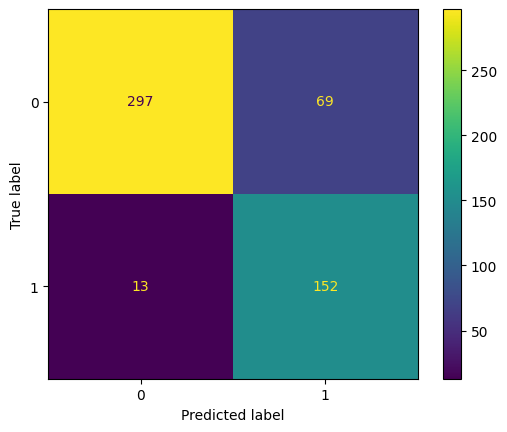

In [20]:
#===================== Threshold Value Manipulation =====================
y_pred_thr_val = (best_pipeline_loaded.predict_proba(X_val)[:,1]>0.45).astype('int')
print(accuracy_score(y_val,y_pred_thr_val))
print(confusion_matrix(y_val,y_pred_thr_val))

print(classification_report(y_val,y_pred_thr_val))

cfm=confusion_matrix(y_val, y_pred_thr_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cfm)
cm_display.plot()
plt.show()